In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.colors as colors
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay
import pmdarima as pm
import statsmodels.api as api
from scipy.stats import norm

from utils import import_data, take_derivative, cut_ends, unit_scale
from models.data_validation import ReportErrors

In [2]:
metadata = pd.read_csv("data/metadata.csv")
metadata.head()

,Node ID,Site ID,Project,Site type,Mount Type,Offset (mm),Dam nearby,Clean,Low Var Obst,High Var Obst,Indeterminate,Outliers,Unnamed: 12
0,001A,ARB025,ARB,River,Bridge - S,4905.50,0,0,1,0,0,0,1
1,001A,MDOT11328,MDO,River,Bridge - D,9448.80,0,0,1,0,0,0,1
2,001A,PTK014,PTK,Stream,Post,1841.50,0,0,1,0,1,0,1
3,003A,ARB017,ARB,Stream,Post,1517.65,0,0,1,0,1,0,1
4,004A,MDOT335,MDO,Lake,Bridge - S,2476.50,0,1,0,0,0,0,1


## First we want to filter out the obvious data faults

These include datasets with saturation, negative values, and extreme value underliers. Datasets are flagged if:
- between 1% and 25% of data are negative
- more than .5% of data are saturated
- between 1% and 10% of data are greater than 3 interquartile distances below the mean

If more than 25% of data are negative, the offset is assumed to be wrong and the dataset is not flagged. 

In [3]:
flags = []
for i in range(len(metadata)):
    df = import_data(index = i)
    offset = metadata.iloc[i]['Offset (mm)']
    df, neg_flag, sat_flag = ReportErrors.detect_out_of_range(df, offset)
    df, und_flag = ReportErrors.detect_underliers(df)
    flags.append({'neg_flag':neg_flag, "sat_flag":sat_flag, "und_flag":und_flag})
    
metadata_mod = metadata.join(pd.DataFrame(flags), how="outer")
print("Negative flags: ", len(metadata_mod[metadata_mod["neg_flag"]==1]))
print("Saturation flags: ", len(metadata_mod[metadata_mod["sat_flag"]==1]))
print("Underlier flags: ", len(metadata_mod[metadata_mod["und_flag"]==1]))
tmp = metadata_mod[metadata_mod["neg_flag"]==0]
tmp = tmp[tmp["sat_flag"]==0]
tmp = tmp[tmp["und_flag"]==0]
print("Test Set: ",len(tmp))
test_set = tmp

Negative flags:  18
Saturation flags:  20
Underlier flags:  9
Test Set:  121


In [4]:
clean = test_set[test_set['Clean']==1]
obst = test_set[test_set['Clean']==0]
print("clean sites: ", len(clean))
print("obstructed sites: ", len(obst))

clean sites:  70
obstructed sites:  51


### Calculate dataset statistics

In [5]:
start_dates = []
stop_dates = []
length = []
for i in range(len(metadata)):
    df = import_data(index = i)
    length.append(len(df))
    start_dates.append(df.index[0])
    stop_dates.append(df.index[-1])

In [6]:
print("average data length:", np.mean(length))
print("average collection time:", np.mean(np.array(stop_dates) - np.array(start_dates)))
print("network start date:", np.min(start_dates))
print("network end date:", np.max(stop_dates))
print("No. unique nodes:",len(np.unique(metadata['Node ID'])))
print("No. unique sites:", len(np.unique(metadata['Site ID'])))

average data length: 27022.83647798742
average collection time: 195 days 02:33:13.377358490
network start date: 2021-04-05 17:02:00+00:00
network end date: 2022-11-28 18:38:00+00:00
No. unique nodes: 114
No. unique sites: 106


## Figure 1

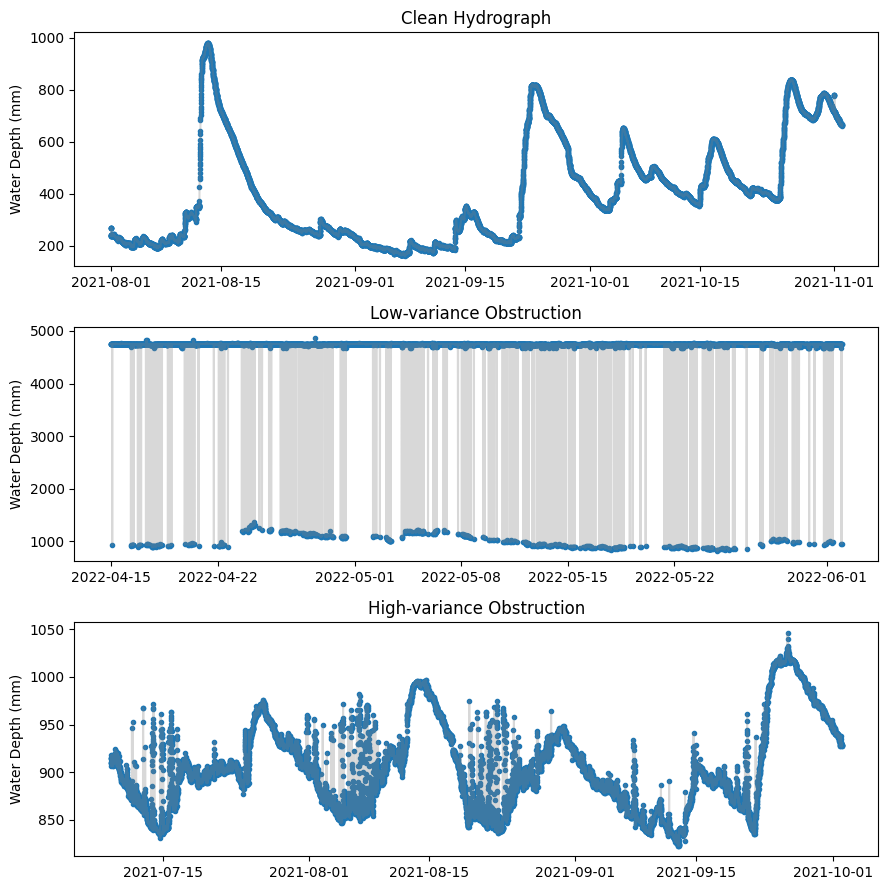

In [7]:
clean_site = import_data(index = 22)
clean_site = clean_site['2021-08-01':'2021-11-01']
lo_var = import_data(index=101)
lo_var = lo_var['2022-04-15':'2022-06-01']
hi_var = import_data(index=13)
hi_var = hi_var['2021-07-01':'2021-10-01']

fig, ax = plt.subplots(nrows=3,figsize=(9,9))
ax[0].scatter(clean_site.index, clean_site['Value'], marker='.')
ax[0].plot(clean_site.index, clean_site['Value'], c='grey', alpha=0.3)
ax[1].scatter(lo_var.index, lo_var['Value'], marker='.')
ax[1].plot(lo_var.index, lo_var['Value'], c='grey', alpha=0.3)
ax[2].scatter(hi_var.index, hi_var['Value'], marker='.')
ax[2].plot(hi_var.index, hi_var['Value'], c='grey', alpha=0.3)
ax[0].set_title("Clean Hydrograph")
ax[1].set_title("Low-variance Obstruction")
ax[2].set_title("High-variance Obstruction")
ax[0].set_ylabel("Water Depth (mm)")
ax[1].set_ylabel("Water Depth (mm)")
ax[2].set_ylabel("Water Depth (mm)")
plt.tight_layout()

## Figure 2

In [8]:
### Define the data for the clean hydrograph ###
df = import_data(index = 82)
df = df[df['Value'] < 1400] # cuts out a few outliers
df = df['2021-08':'2022-01-20']
sub_df = df["2021-10-25 00:00:00+00:00":"2021-10-30 00:00:00+00:00"]
df, df_down, df_up = take_derivative(df)
sub_df, sub_df_down, sub_df_up = take_derivative(sub_df)

In [9]:
### Define the data for the obstructed hydrograph ###
obst = import_data(index = 68)
obst_plot = obst[obst['Value'] >0]
obst_plot = obst_plot[obst_plot['Value'] < 1200]
obst_c = cut_ends(obst)
obst_c, obst_down, obst_up = take_derivative(obst_c)

### Manually highlight clusters of obstructed data ###
outliers_1 = np.where(obst_down['Value'] > 800, -1, 0)
outliers_2 = np.where(obst_down['mean diff'] < -0.012, -1, 0)
outliers_3 = np.where(obst_down['mean diff'] > -0.0025, -1, 0)
outliers = np.where(outliers_1 + outliers_2 + outliers_3== -2, -1, 0)

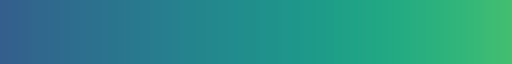

In [10]:
### Define a trimmed version of viridis to keep colors consistent ###
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('viridis')
short_viridis = truncate_colormap(cmap, 0.3, 0.7)
short_viridis

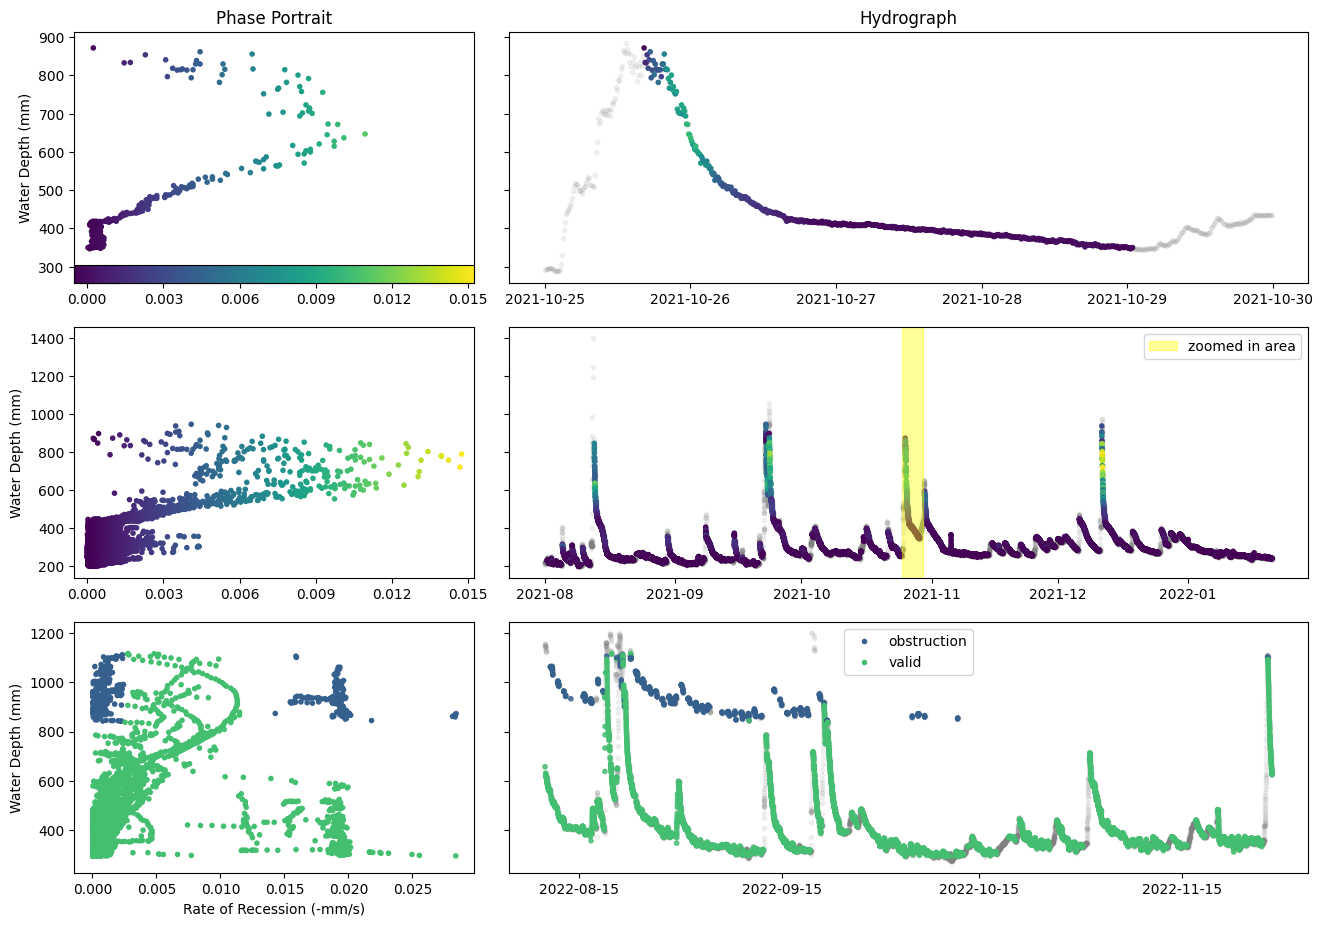

In [11]:
### Plot Figure 2 ###
fig, ax = plt.subplots(ncols=2, nrows=3, figsize = (14, 9), sharey='row', gridspec_kw={'width_ratios': [1, 2]})
plt.tight_layout()
norm = mpl.colors.Normalize(vmin=min(-1*df_down['mean diff']), vmax=max(-1*df_down['mean diff']))
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
from matplotlib import cm
color_range = cm.get_cmap('viridis', len(-1*df_down['mean diff']))
ax[1,1].scatter(df.index, df['Value'], marker = '.', color='grey', alpha=0.1)
ax[1,0].scatter(-1*df_down['mean diff'], df_down['Value'], marker='.', c=-1*df_down['mean diff'], cmap=color_range, norm=norm)
ax[1,1].scatter(df_down.index, df_down['Value'], c=-1*df_down['mean diff'], cmap=color_range, marker = '.', norm=norm)
ax[1,0].set_ylabel('Water Depth (mm)')

ax[1,1].axvspan("2021-10-25 00:00:00+00:00","2021-10-30 00:00:00+00:00", alpha=0.4, color='yellow', label="zoomed in area")
ax[1,1].legend()
ax[0,1].scatter(sub_df.index, sub_df['Value'], marker = '.', color='grey', alpha=0.1)
ax[0,0].scatter(-1*sub_df_down['mean diff'], sub_df_down['Value'], marker='.',c=-1*sub_df_down['mean diff'], cmap=color_range, norm=norm)

ax[0,1].scatter(sub_df_down.index, sub_df_down['Value'], c=-1*sub_df_down['mean diff'], cmap=color_range, marker = '.', norm=norm)
ax[1,0].set_xticks([0.000, 0.003, 0.006, 0.009, 0.012, 0.015])
ax[0,0].set_ylabel('Water Depth (mm)')

ax[0,1].set_title("Hydrograph")
ax[0,0].set_title("Phase Portrait")
ax[0,0].set_xticks([0.000, 0.003, 0.006, 0.009, 0.012, 0.015])
ax[0,0].set_xlim([-0.0005,max(-1*df_down['mean diff'])+0.0005])
ax[1,0].set_xlim([-0.0005,max(-1*df_down['mean diff'])+0.0005])

ax1_divider = make_axes_locatable(ax[0,0])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="-7%")
cbar = plt.colorbar(sm, orientation="horizontal", cax=cax1)
cbar.set_ticks([])

ax[2,0].scatter(-1*obst_down['mean diff'], obst_down['Value'], marker='.', c=outliers, cmap=short_viridis)
ax[2,1].scatter(obst_plot.index, obst_plot['Value'], marker='.', c='grey', alpha=0.1)
ax[2,1].scatter(obst_down.index, obst_down['Value'], marker='.', c=outliers, cmap=short_viridis, alpha=0.8)
ax[2,1].set_xticks(['2022-08-15', '2022-09-15', '2022-10-15', '2022-11-15'])
ax[2,0].set_ylabel('Water Depth (mm)')

ax[2,0].set_xlabel('Rate of Recession (-mm/s)')
legend_elements = [Line2D([0], [0], marker='.', linewidth=0, markerfacecolor=short_viridis(0),c=short_viridis(0), label='obstruction'),
                   Line2D([0], [0], marker='.', linewidth=0, markerfacecolor=short_viridis(0.99),c=short_viridis(0.99), label='valid',)]
ax[2,1].legend(handles=legend_elements)

plt.subplots_adjust(left=0.1)
# plt.savefig('Figure2.png', dpi=300)

### Figure 3

In [14]:
def format_data(nbins=10):
    # define true value labels
    y = []
    for i in range(len(test_set)):
        if test_set.iloc[i]['Clean'] == 1:
            y.append(0)
        else:
            y.append(1)
    
    # encode X feature set
    data = []
    for i, col in test_set.iterrows():
        df = import_data(index = i)
        df = cut_ends(df)
        df, df_down, df_up = take_derivative(df)
        if len(df_down) == 0:
            X = np.zeros((nbins,nbins))
        else:
            X = unit_scale(df_down)
        h, x_e, y_e = np.histogram2d(X[:,0], X[:,1],nbins)
        mm = make_pipeline(StandardScaler(), MinMaxScaler())
        h = mm.fit_transform(h)

        data.append(np.ndarray.flatten(h))
        
    return np.array(data), np.array(y)

In [16]:
data, y = format_data()
pp = data.reshape(121,10,10)
mean_c = np.mean(pp[np.where(y==0)], axis=0) # calculate mean clean phase portrait
mean_o = np.mean(pp[np.where(y==1)], axis=0) # calculate mean obstructed phase portrait
clean_sim = (data @ mean_c.flatten()) # calculate dataset similarity to clean phase portrait
obst_sim = (data @ mean_o.flatten()) # calculate dataset similarity to obstructed phase portrait

/var/folders/rh/hgz2vvm17rqb8qqf31l58v2c0000gn/T/ipykernel_53161/2369835765.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


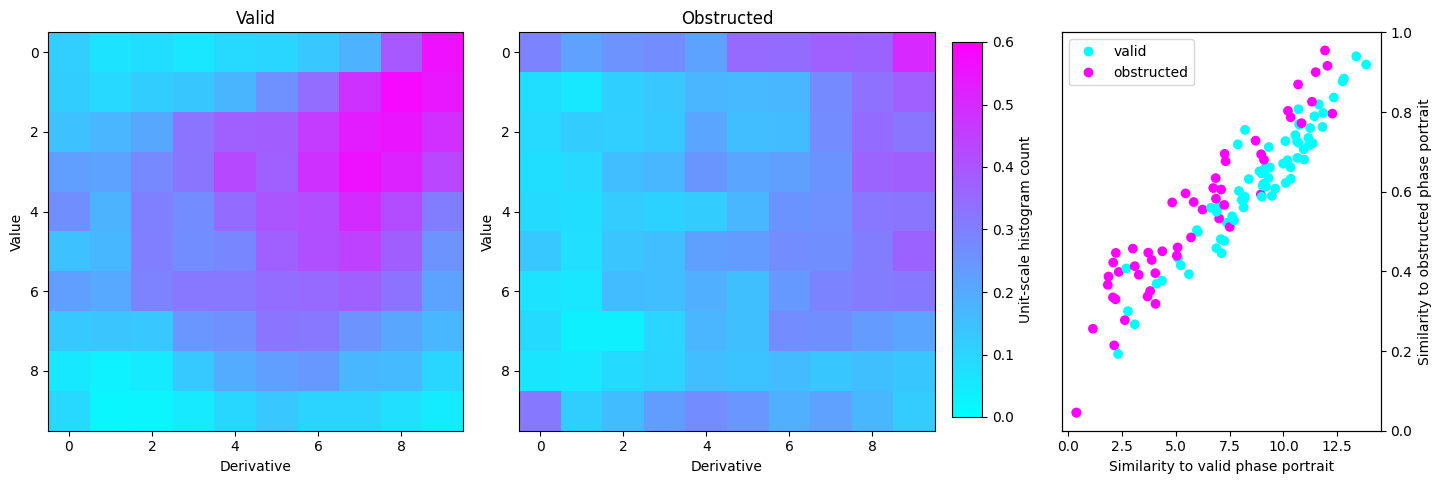

In [19]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5), gridspec_kw={'width_ratios':[0.9,0.9,1]})
im = ax[1].imshow(mean_o, cmap='cool', aspect='auto',vmin=0, vmax=0.6)
ax[1].set_title("Obstructed")
ax[0].imshow(mean_c, cmap='cool', aspect='auto',vmin=0, vmax=0.6)
ax[0].set_title("Valid")
ax[0].set_xlabel("Derivative")
ax[0].set_ylabel("Value")
ax[1].set_xlabel("Derivative")
ax[1].set_ylabel("Value")
cax = fig.add_axes([0.64, 0.15, 0.02, 0.75])
fig.colorbar(im, orientation='vertical', cax=cax, label="Unit-scale histogram count")

ax[2].scatter(clean_sim, obst_sim, c=y, cmap='cool', marker='o')
ax[2].set_xlabel("Similarity to valid phase portrait")
ax2 = ax[2].twinx()
ax[2].set_yticks([])
ax2.set_ylabel("Similarity to obstructed phase portrait")
ax[2].set_box_aspect(1.25)

# define a custom legend
cmap = plt.get_cmap('cool')
cool = truncate_colormap(cmap, 0, 1.0)
legend_elements = [Line2D([0], [0], marker='o', linewidth=0, markerfacecolor=cool(0),c=cool(0), label='valid'),
                   Line2D([0], [0], marker='o', linewidth=0, markerfacecolor=cool(0.99),c=cool(0.99), label='obstructed',)]
ax[2].legend(handles=legend_elements)

plt.rc('font', size=12)
plt.tight_layout()
# plt.savefig("figure3a.png")

In [24]:
# run binary classifier
clf = MLPClassifier(alpha=0.001, random_state=1)
y_pred = cross_val_predict(clf, data, y, cv=5)

/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multi

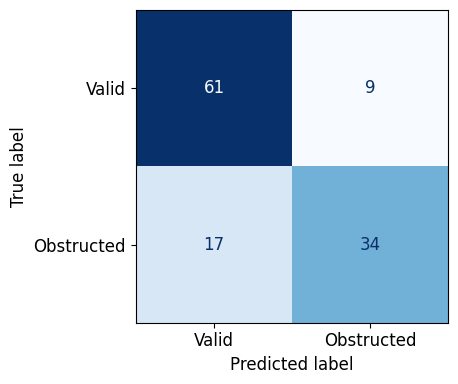

In [27]:
fig, ax = plt.subplots(figsize=(6,4))
ConfusionMatrixDisplay.from_predictions(y,y_pred, cmap='Blues', ax=ax, 
                                        colorbar=False, display_labels=["Valid", "Obstructed"])
plt.tight_layout()

In [30]:
# grab example false negative and false positive time series
df1 = import_data(index = 16)
df2 = import_data(index = 111)
df2 = cut_ends(df2)
df3 = import_data(index = 13)
df4 = import_data(index = 59)
df4b = cut_ends(df4)

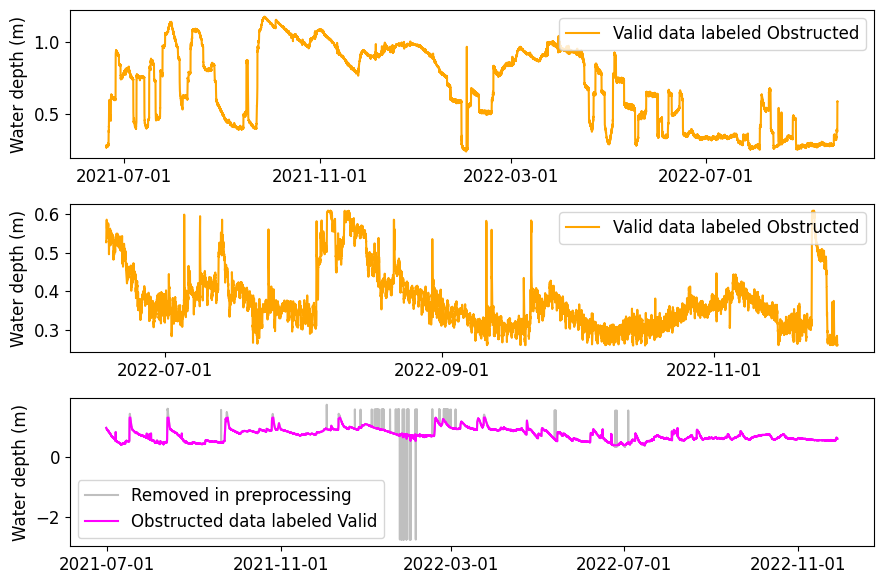

In [31]:
fig, ax = plt.subplots(nrows=3, figsize=(9,6))
ax[0].plot(df1.index, df1['Value']/1000, c='orange', label='Valid data labeled Obstructed')
ax[1].plot(df2.index, df2['Value']/1000, c='orange', label='Valid data labeled Obstructed')
ax[2].plot(df4.index, df4['Value']/1000, c='grey', alpha=0.5, label='Removed in preprocessing')
ax[2].plot(df4b.index, df4b['Value']/1000, c='magenta', label='Obstructed data labeled Valid')
ax[0].set_ylabel("Water depth (m)")
ax[1].set_ylabel("Water depth (m)")
ax[2].set_ylabel("Water depth (m)")
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_xticks(["2021-07", "2021-11","2022-03","2022-07"])
ax[1].set_xticks(["2022-07", "2022-09","2022-11"])
ax[2].set_xticks(["2021-07", "2021-11","2022-03","2022-07", "2022-11"])

plt.tight_layout()
# plt.savefig("figure3d.png")

## Figure 4

In [56]:
df = import_data(index = 0)
df, df_down, df_up = take_derivative(df)
X = unit_scale(df_down)
labels = ReportErrors.DBSCAN_label(X, eps=ReportErrors.return_eps(X))
marked = df_down.iloc[np.where(labels==-1)[0]]
clean = df_down.iloc[np.where(labels==0)[0]]

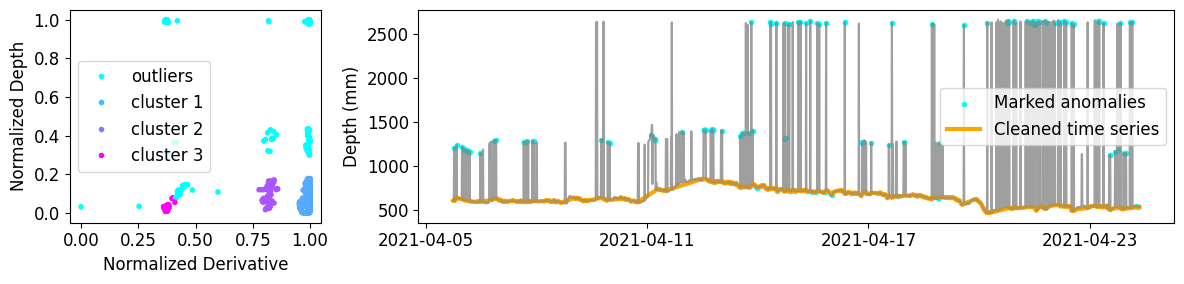

In [57]:
fig, ax = plt.subplots(figsize=(12,3), ncols=2, gridspec_kw={'width_ratios':(1,3)})
ax[1].scatter(marked.index, marked['Value'], c='cyan', marker='.', label='Marked anomalies')
ax[0].scatter(X[:,1], X[:,0], marker='.', c=labels, cmap='cool')

ax[1].plot(df.index, df['Value'], c='grey', alpha=0.5)
ax[1].plot(clean.index, clean['Value'], c='orange', label="Cleaned time series", linewidth=3)
ax[0].set_xlabel("Normalized Derivative")
ax[0].set_ylabel("Normalized Depth")
ax[1].set_ylabel("Depth (mm)")
ax[1].plot(df.index, df['Value'], c='grey', alpha=0.5)
ax[1].set_xticks(["2021-04-05", "2021-04-11","2021-04-17","2021-04-23"])
ax[1].legend()

# Create custom legend
cmap = plt.get_cmap('cool')
cool = truncate_colormap(cmap, 0, 1.0)
legend_elements = [Line2D([0], [0], marker='.', linewidth=0, markerfacecolor=cool(0),c=cool(0), label='outliers'),
                   Line2D([0], [0], marker='.', linewidth=0, markerfacecolor=cool(0.25),c=cool(0.25), label='cluster 1',),
                   Line2D([0], [0], marker='.', linewidth=0, markerfacecolor=cool(0.5),c=cool(0.5), label='cluster 2',),
                   Line2D([0], [0], marker='.', linewidth=0, markerfacecolor=cool(0.99),c=cool(0.99), label='cluster 3',)]
ax[0].legend(handles=legend_elements)
plt.tight_layout()
# plt.savefig("figure4a.png")

In [62]:
df = import_data(index = 0)
model = pm.auto_arima(np.array(df), seasonal=False, suppress_warnings=True, error_action="ignore")
(p, d, q) = model.order
model = api.tsa.SARIMAX(df, order=(p, d, q))
model_fit = model.fit(disp=0, warn_convergence=False)
residuals = pd.DataFrame(model_fit.resid)
predict = model_fit.get_prediction()
predictions = pd.DataFrame(predict.predicted_mean)
residuals[0][0] = 0

/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [66]:
alpha=0.01
window_sz=6*24
min_range=0.0
threshold = []  # initialize empty list to hold thresholds
z = norm.ppf(1 - alpha / 2)
if (window_sz > len(residuals)):
    print("WARNING: in set_dynamic_threshold(), window_sz > len(data)! Reducing window_sz.")
    window_sz = len(residuals)  # reduce the window to the max allowable

# loop through data and add each threshold pair
for i in range(0, len(residuals)):
    if (window_sz > i):  # index is closer than window size to left edge of data
        lo = 0
    else:  # look back as far as the window size
        lo = i - window_sz
    if (i + window_sz > len(residuals)):  # index is close to right edge of data
        hi = len(residuals)
    else:  # look forward as far as the window size
        hi = i + window_sz

    # calculate the range of probable values using given alpha
    mean = residuals[0][lo:(hi + 1)].mean()
    sigma = residuals[0][lo:(hi + 1)].std()
    th_range = z * sigma
    if (th_range < min_range):
        th_range = min_range
    # append pair of upper and lower thrsholds
    threshold.append([mean - th_range, mean + th_range])

threshold = pd.DataFrame(threshold, columns=['low', 'high'])

In [72]:
up_outliers = df[df['Value'] > predictions['predicted_mean'] + np.array(threshold['high'])]
down_outliers = df[df['Value'] < predictions['predicted_mean'] + np.array(threshold['low'])]
arima_clean = df.copy()
arima_clean = arima_clean.drop(up_outliers.index)
arima_clean = arima_clean.drop(down_outliers.index)

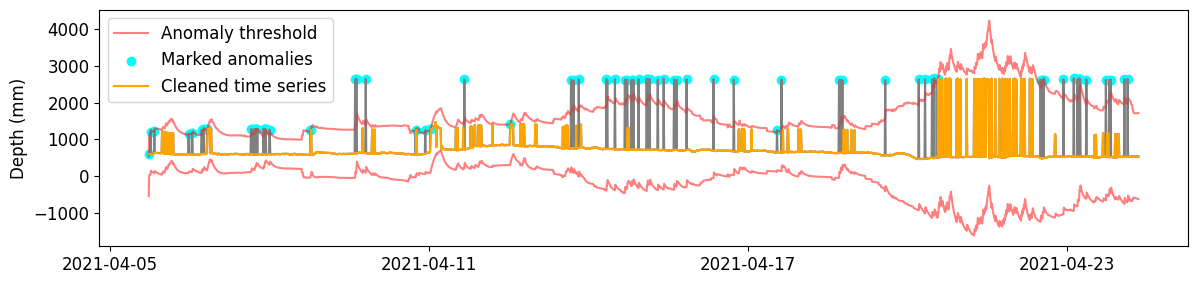

In [73]:
fig, ax = plt.subplots(figsize=(12,3))
plt.plot(df.index, df['Value'], c='grey')
plt.plot(df.index, predictions['predicted_mean'] + np.array(threshold['low']), c='red', alpha=0.5, label='Anomaly threshold')
plt.plot(df.index, predictions['predicted_mean'] + np.array(threshold['high']), c='red', alpha=0.5)
plt.scatter(up_outliers.index, up_outliers['Value'], c='cyan', label='Marked anomalies')
plt.scatter(down_outliers.index, down_outliers['Value'], c='cyan')
ax.plot(df.index, df['Value'], c='grey', alpha=0.5)
ax.plot(arima_clean.index, arima_clean['Value'], c='orange', label="Cleaned time series")
plt.ylabel("Depth (mm)")
plt.legend()
ax.set_xticks(["2021-04-05", "2021-04-11","2021-04-17","2021-04-23"])
plt.tight_layout()
# plt.savefig("figure4b.png")

## Supporting Information 1

In [32]:
df = import_data(index = 82)

In [34]:
usgs = pd.read_csv('data/usgs_mallets.csv')
usgs['datetime'] = pd.to_datetime(usgs['datetime'])

In [35]:
usgs.index = usgs['datetime']

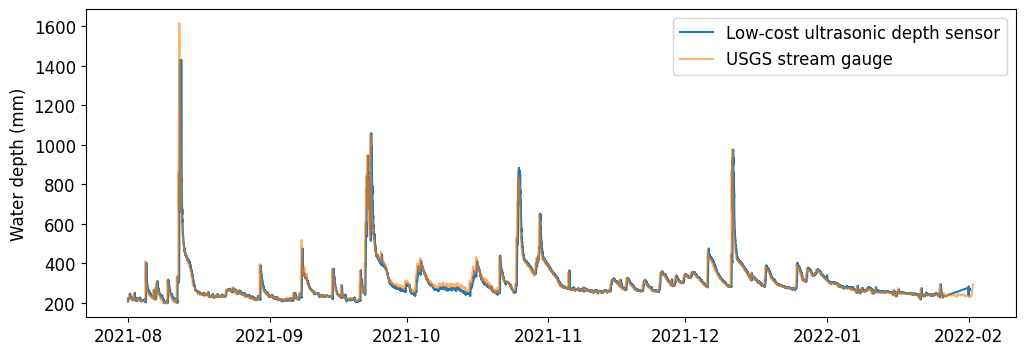

In [36]:
datum_offset = np.mean(usgs['Value']*304.8) - np.mean(df['Value'])

fig, ax = plt.subplots(figsize=(12,4))
plt.plot(df['2021-08':'2022-02'], alpha=1, label="Low-cost ultrasonic depth sensor")
plt.plot(usgs.index, usgs['Value']*304.8 - datum_offset, alpha=0.6, label="USGS stream gauge")
plt.legend()
plt.ylabel("Water depth (mm)")
plt.savefig("appendix1.png", dpi=300)

## Supporting Information 3

Show false classifications of hydrographs
- false negatives are pink
- false positives are orange

In [37]:
clf = MLPClassifier(alpha=0.001, random_state=1) #0.76 to 0.78
y_pred = cross_val_predict(clf, data, y, cv=5)

/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multi

In [42]:
fn = np.where(y - y_pred ==1)[0] # grab false negatives
fp = np.where(y - y_pred == -1)[0] # grab false positives

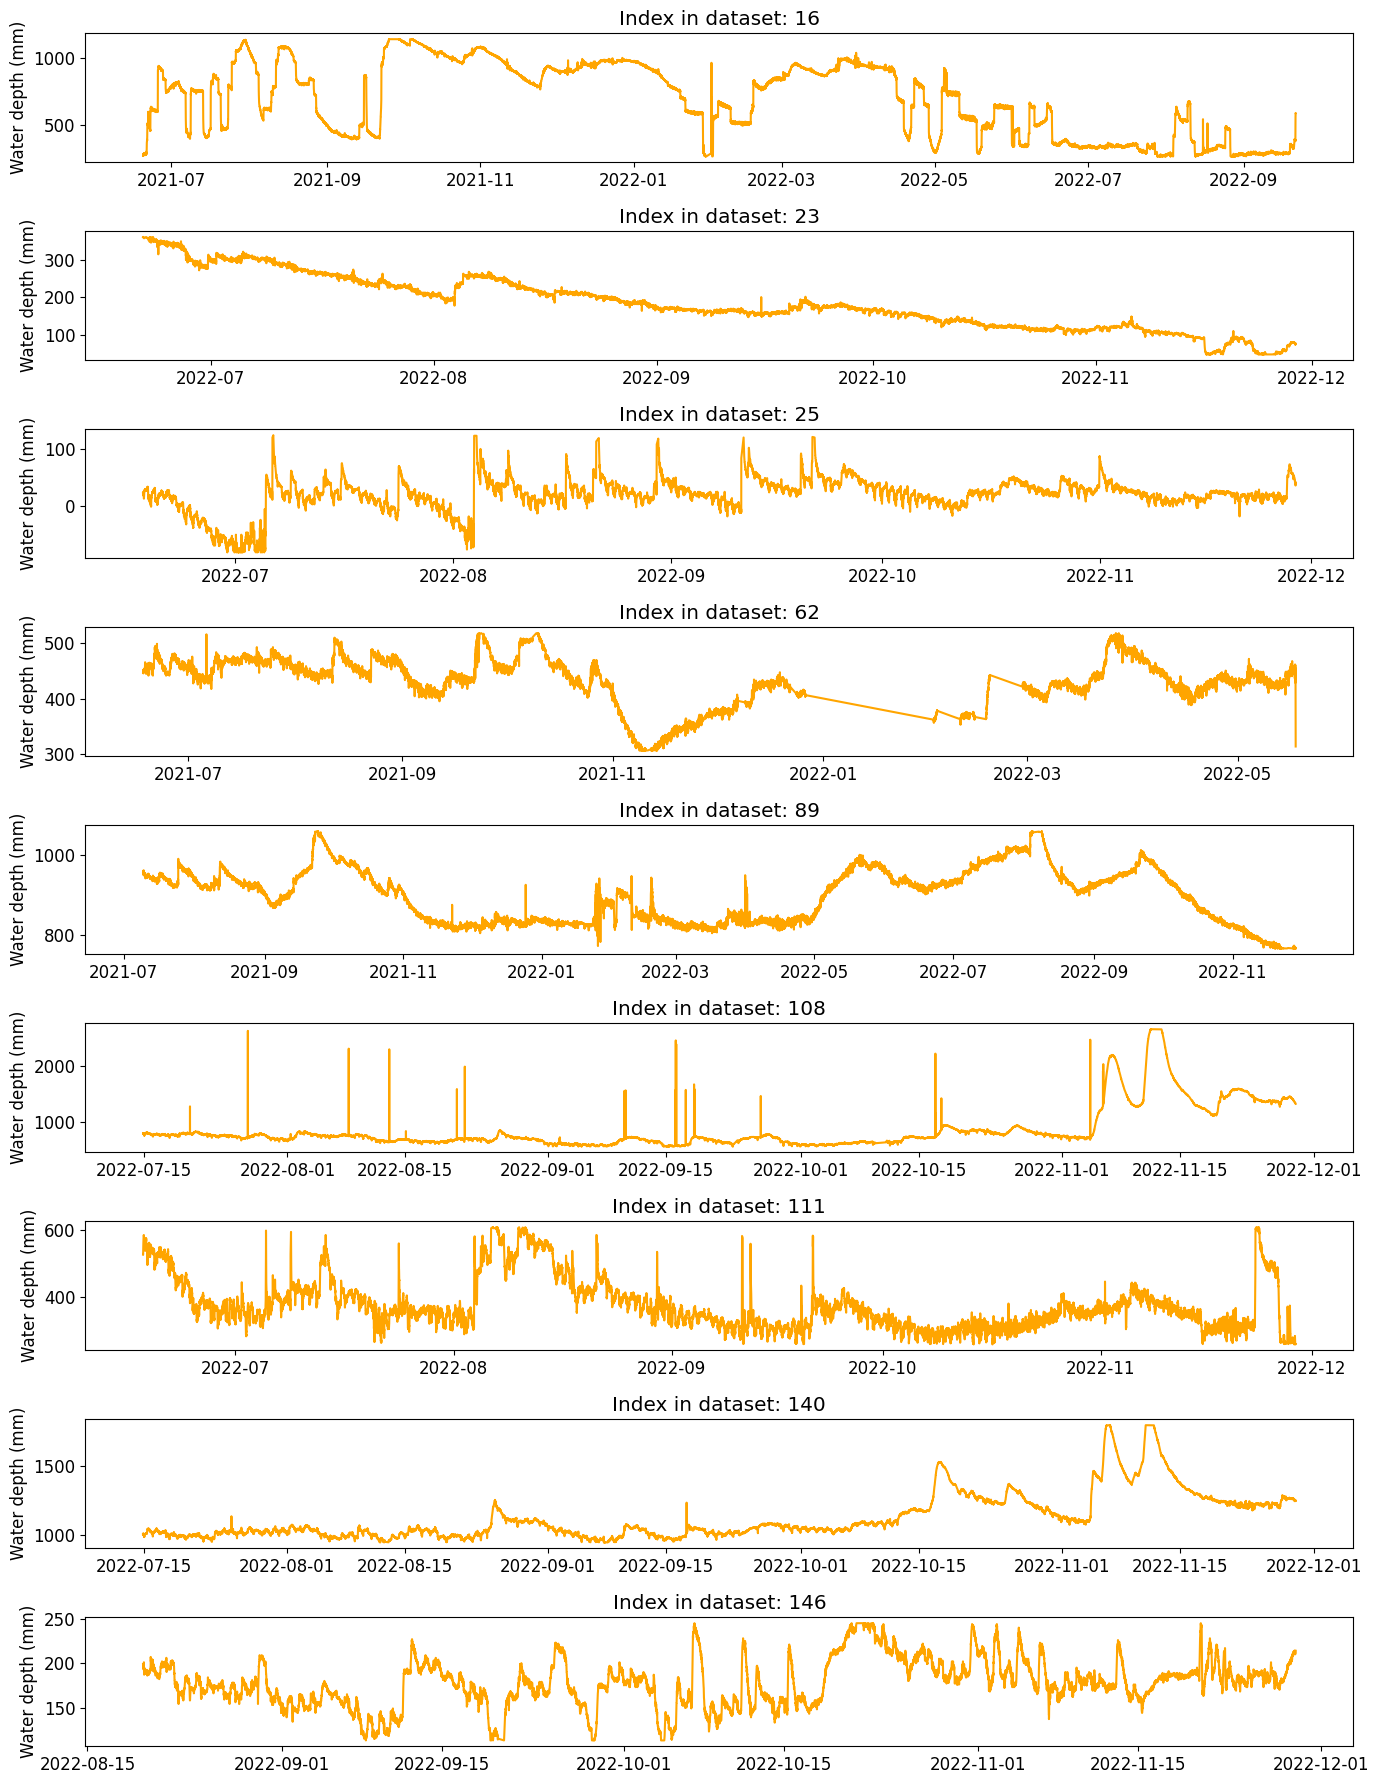

In [44]:
fig, ax = plt.subplots(nrows=9, figsize=(14,9*2))
c=0
for i in fp:
    j = test_set.index[i]
    df = import_data(index = j)
    df = cut_ends(df)
    ax[c].plot(df.index, df['Value'], c='orange')
    ax[c].set_title(f"Index in dataset: {j}")
    ax[c].set_ylabel("Water depth (mm)")
    c+=1
plt.tight_layout()
plt.savefig("Appendix2_falsepos.png")

In [46]:
fn1 = fn[0:9]
fn2 = fn[9:]

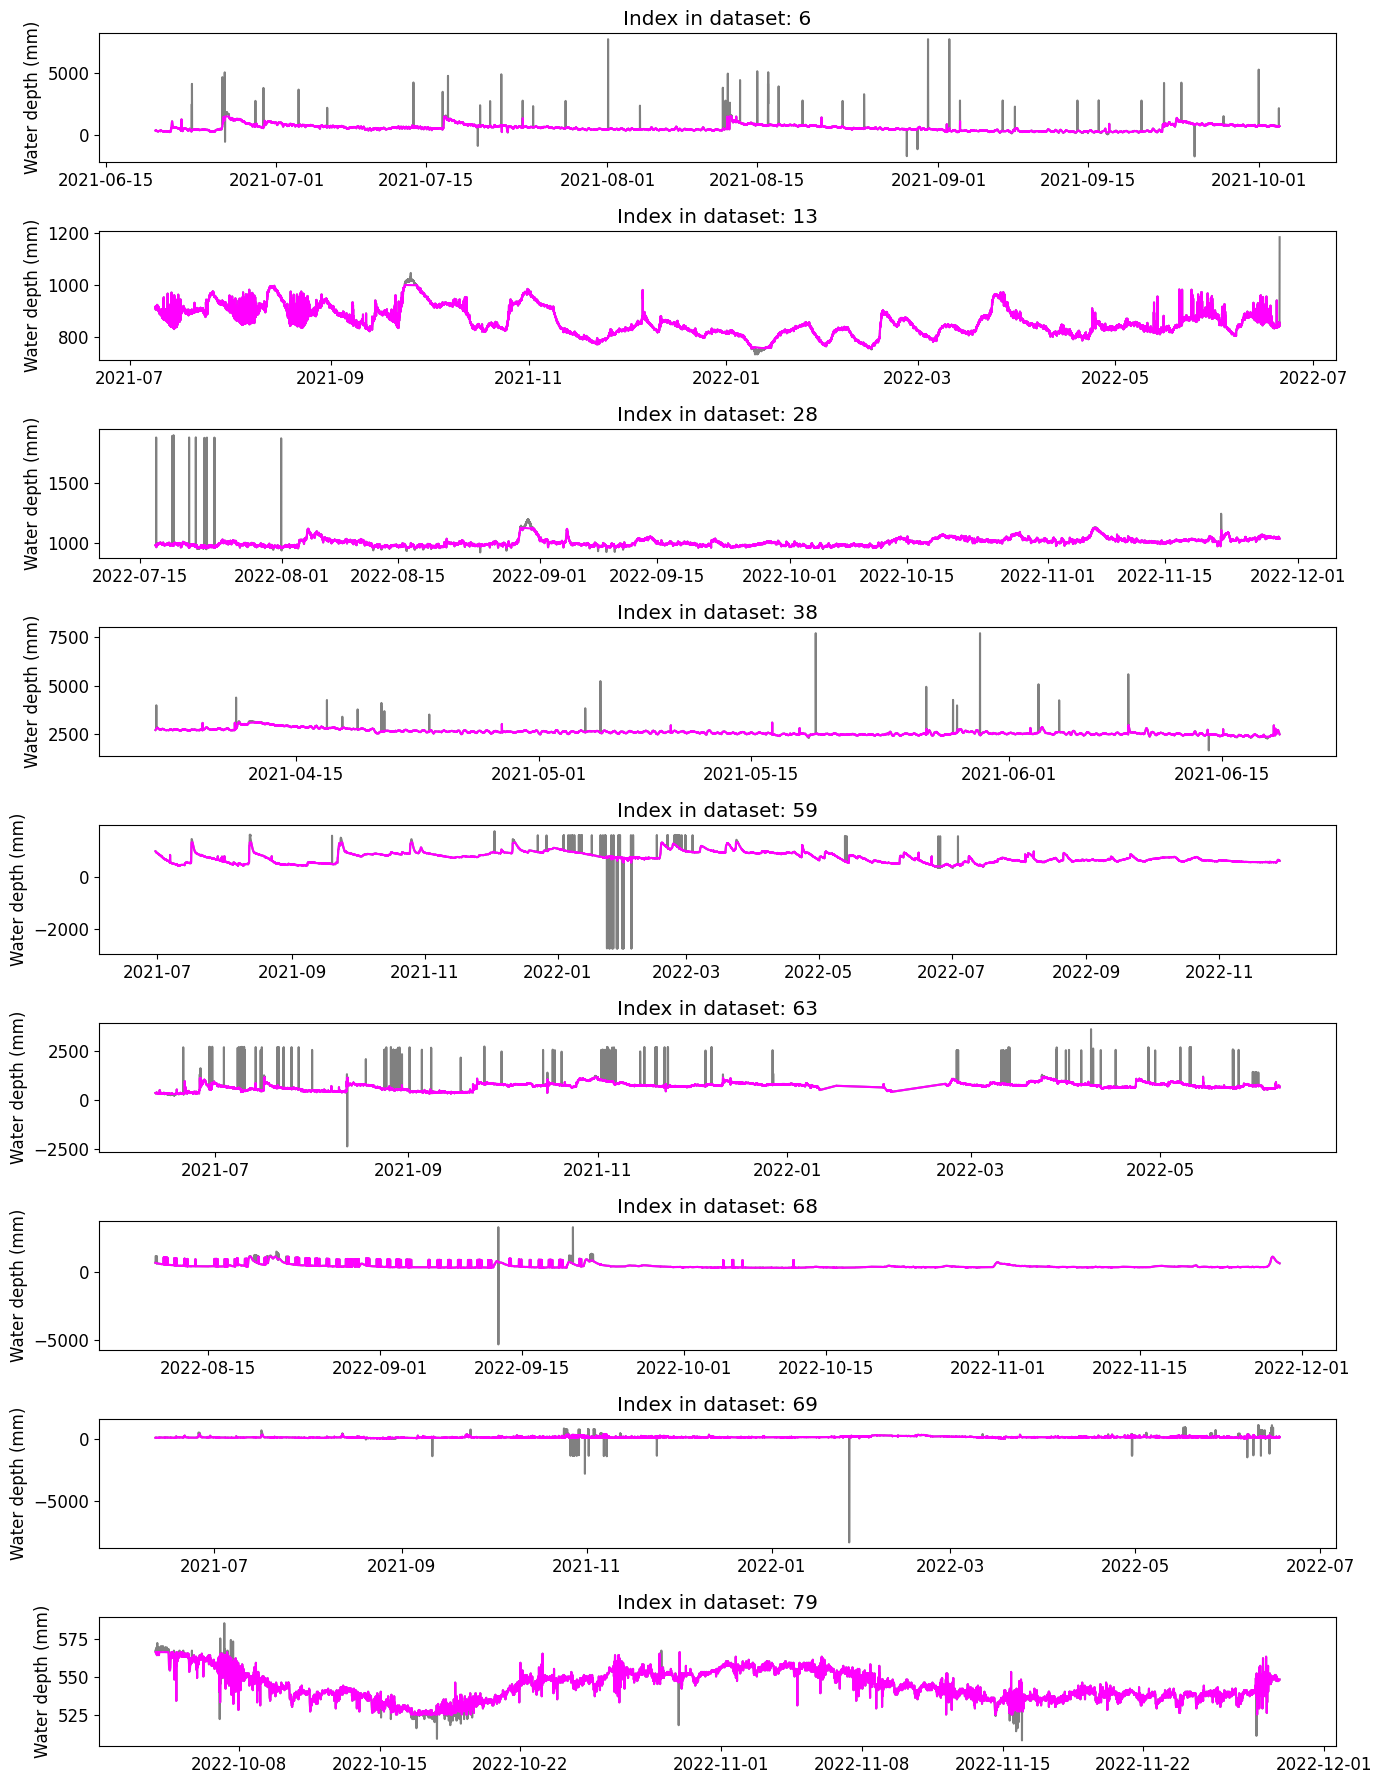

In [47]:
fig, ax = plt.subplots(nrows=9, figsize=(14,9*2))
c=0
for i in fn1:
    j = test_set.index[i]
    df = import_data(index = j)
    ax[c].plot(df.index, df['Value'], c='grey')
    df = cut_ends(df)
    ax[c].plot(df.index, df['Value'], c='magenta')
    ax[c].set_title(f"Index in dataset: {j}")
    ax[c].set_ylabel("Water depth (mm)")
    c+=1
plt.tight_layout()
plt.savefig("Appendix2_falsenegat1.png")

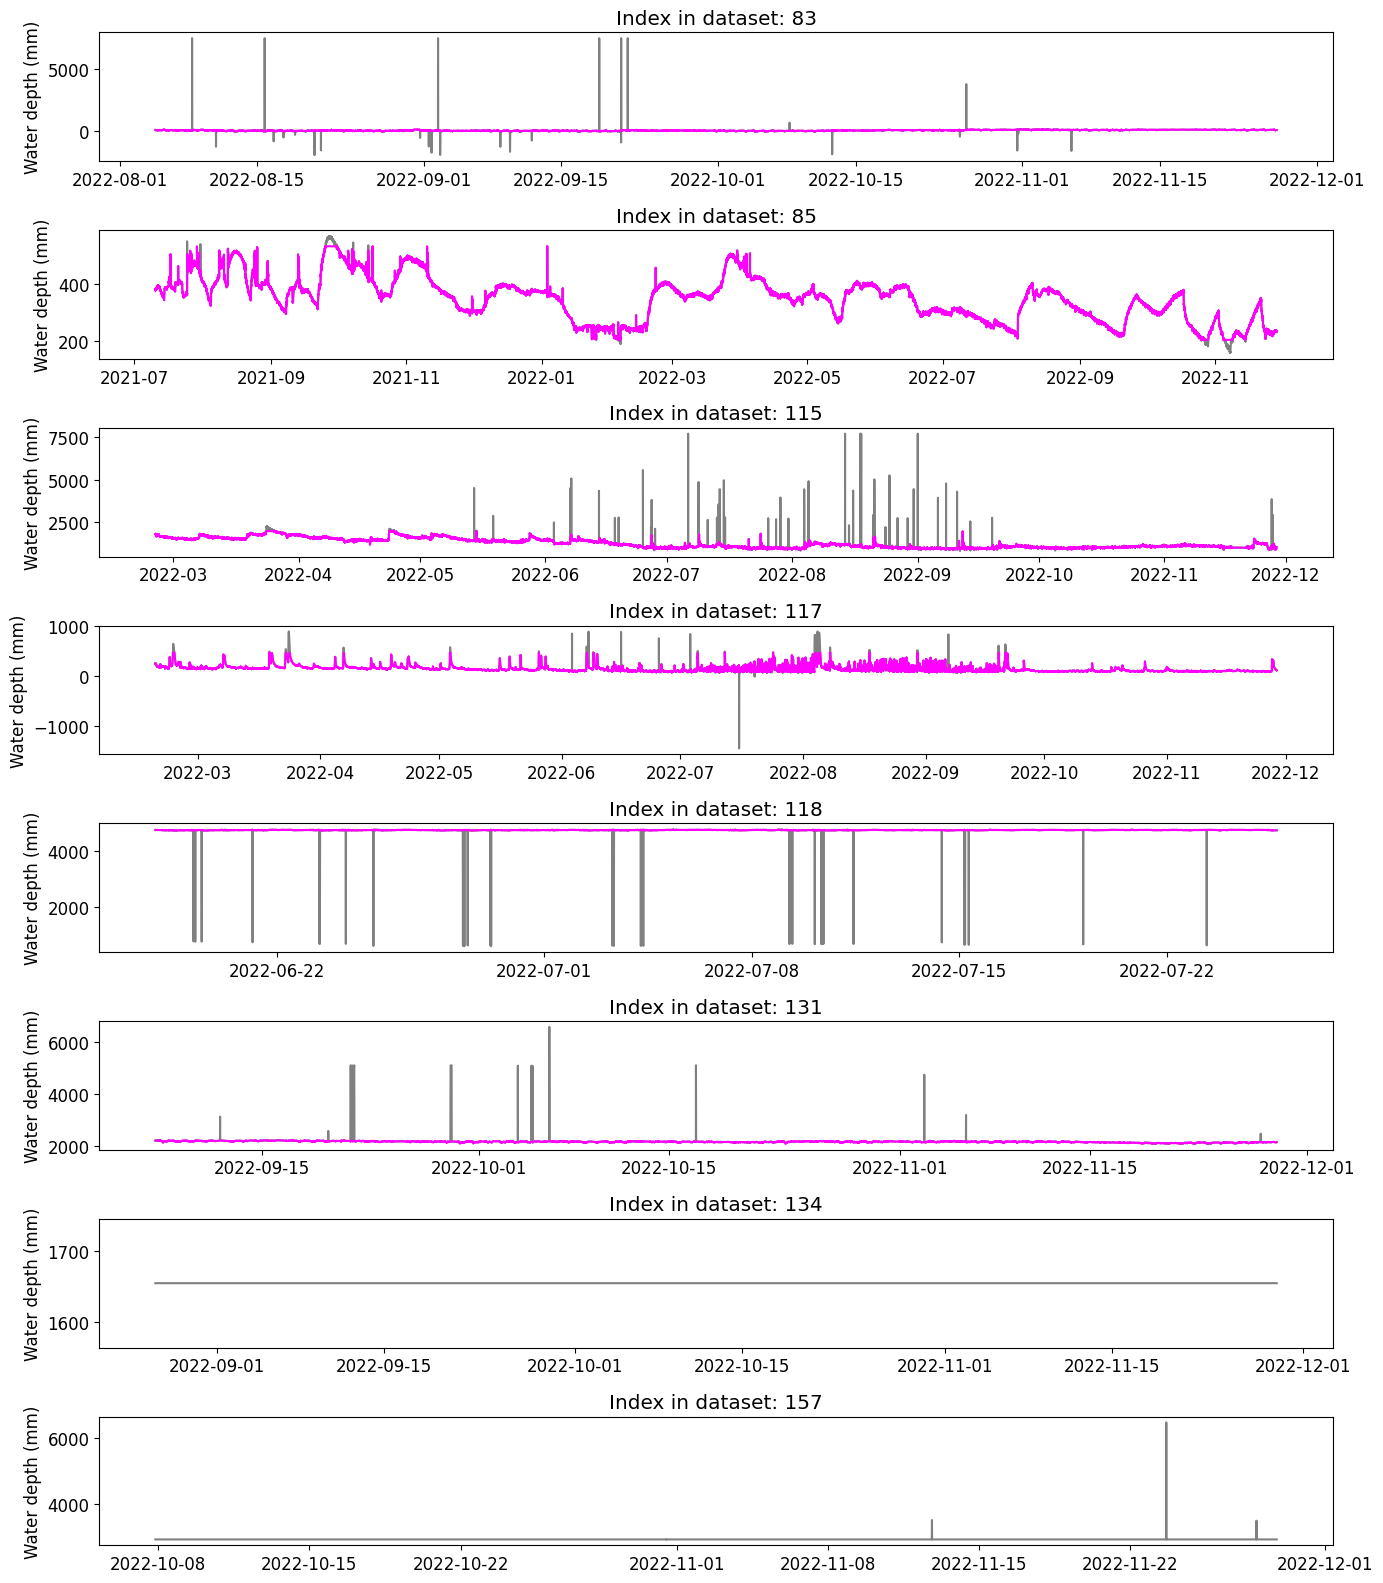

In [48]:
fig, ax = plt.subplots(nrows=8, figsize=(14,8*2))
c=0
for i in fn2:
    j = test_set.index[i]
    df = import_data(index = j)
    ax[c].plot(df.index, df['Value'], c='grey')
    df = cut_ends(df)
    ax[c].plot(df.index, df['Value'], c='magenta')
    ax[c].set_title(f"Index in dataset: {j}")
    ax[c].set_ylabel("Water depth (mm)")
    c+=1
plt.tight_layout()
plt.savefig("Appendix2_falsenegat2.png")

## Supporting Information 4

In [78]:
def dbscan_detection(df, eps=0.025):
    df, df_down, df_up = take_derivative(df)
    X = unit_scale(df_down)
    labels = ReportErrors.DBSCAN_label(X, eps=eps)
    marked = df_down.iloc[np.where(labels==-1)[0]]
    
    fig, ax = plt.subplots(figsize=(12,4), ncols=2, gridspec_kw={'width_ratios':(1,2)})
    ax[1].scatter(marked.index, marked['Value'], c='cyan', marker='.', label='Marked anomalies')
    ax[0].scatter(X[:,1], X[:,0], marker='.', c=labels, cmap='cool')
    ax[1].scatter(df_down.index, df_down['Value'], c=labels, cmap='cool', marker='.')
    ax[1].plot(df_down.index, df_down['Value'], c='grey', alpha=0.2)
    ax[0].set_xlabel("Normalized Derivative")
    ax[0].set_ylabel("Normalized Depth")
    ax[1].set_ylabel("Depth (mm)")
#     ax[1].legend()
    plt.tight_layout()
    return plt.show()

In [75]:
def run_arima_detection(df, alpha=0.01, window_sz=48):
    model = pm.auto_arima(np.array(df), seasonal=False, suppress_warnings=True, error_action="ignore")
    (p, d, q) = model.order
    model = api.tsa.SARIMAX(df, order=(p, d, q))
    model_fit = model.fit(disp=0, warn_convergence=False)
    residuals = pd.DataFrame(model_fit.resid)
    predict = model_fit.get_prediction()
    predictions = pd.DataFrame(predict.predicted_mean)
    residuals[0][0] = 0
    
    alpha=alpha
    window_sz=window_sz
    min_range=0.0
    threshold = []  # initialize empty list to hold thresholds
    z = norm.ppf(1 - alpha / 2)
    if (window_sz > len(residuals)):
        print("WARNING: in set_dynamic_threshold(), window_sz > len(data)! Reducing window_sz.")
        window_sz = len(residuals)  # reduce the window to the max allowable

    # loop through data and add each threshold pair
    for i in range(0, len(residuals)):
        if (window_sz > i):  # index is closer than window size to left edge of data
            lo = 0
        else:  # look back as far as the window size
            lo = i - window_sz
        if (i + window_sz > len(residuals)):  # index is close to right edge of data
            hi = len(residuals)
        else:  # look forward as far as the window size
            hi = i + window_sz

        # calculate the range of probable values using given alpha
        mean = residuals[0][lo:(hi + 1)].mean()
        sigma = residuals[0][lo:(hi + 1)].std()
        th_range = z * sigma
        if (th_range < min_range):
            th_range = min_range
        # append pair of upper and lower thrsholds
        threshold.append([mean - th_range, mean + th_range])

    threshold = pd.DataFrame(threshold, columns=['low', 'high'])
    predictions.iloc[0]['predicted_mean'] = df['Value'].iloc[0]
    
    up_outliers = df[df['Value'] > predictions['predicted_mean'] + np.array(threshold['high'])]
    down_outliers = df[df['Value'] < predictions['predicted_mean'] + np.array(threshold['low'])]
    
    fig, ax = plt.subplots(figsize=(12,4))
    plt.plot(df.index, df['Value'], c='grey')
    plt.plot(df.index, predictions['predicted_mean'] + np.array(threshold['low']), c='red', alpha=0.5, label='Anomaly threshold')
    plt.plot(df.index, predictions['predicted_mean'] + np.array(threshold['high']), c='red', alpha=0.5)
    plt.scatter(up_outliers.index, up_outliers['Value'], c='cyan', label='Marked anomalies')
    plt.scatter(down_outliers.index, down_outliers['Value'], c='cyan')
    plt.ylabel("Depth (mm)")
    plt.legend()
    plt.tight_layout()
    
    return plt.show()

/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


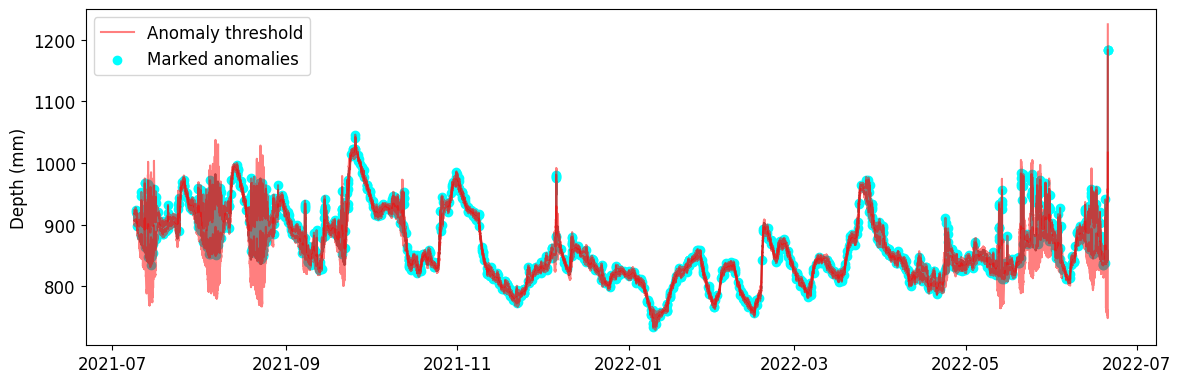

In [76]:
df = import_data(index = 13)
df = df[df['Value'] >0]
df = df[df['Value'] < 1200]
run_arima_detection(df, window_sz=96, alpha=0.01)

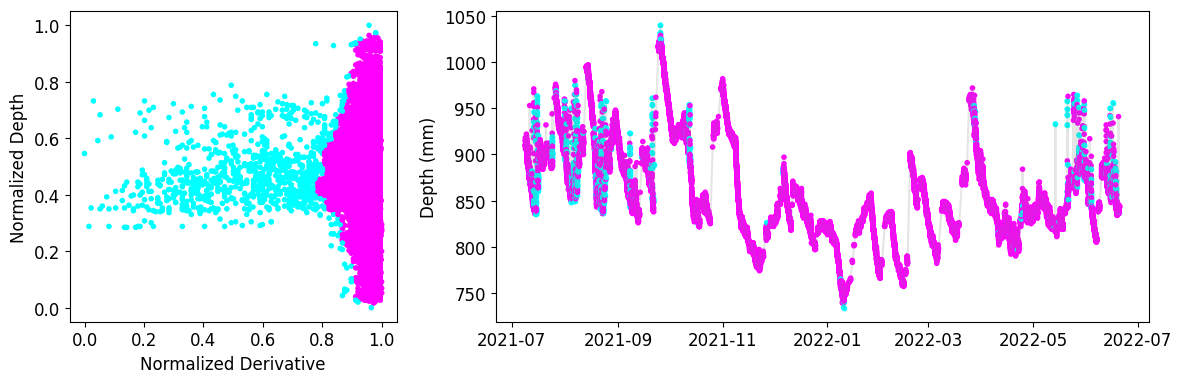

In [79]:
dbscan_detection(df, eps=0.025)

/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


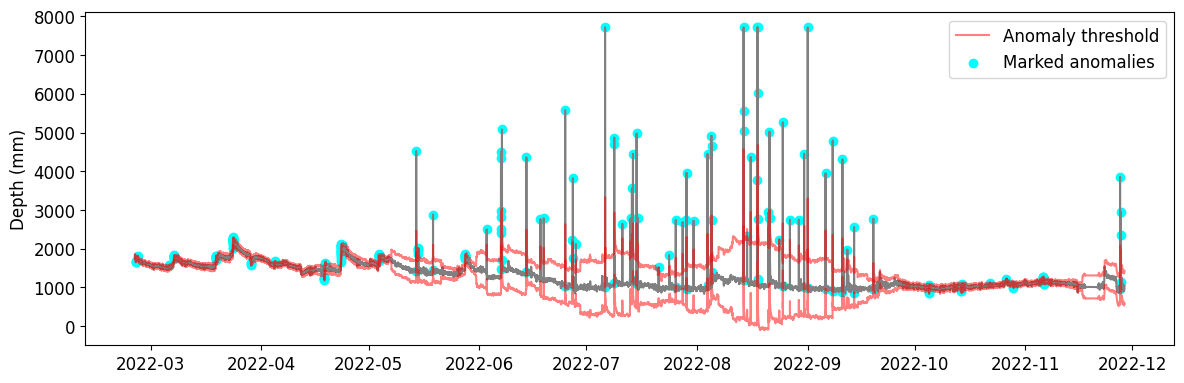

In [80]:
df = import_data(index = 115)
run_arima_detection(df, window_sz=1000, alpha=0.001)

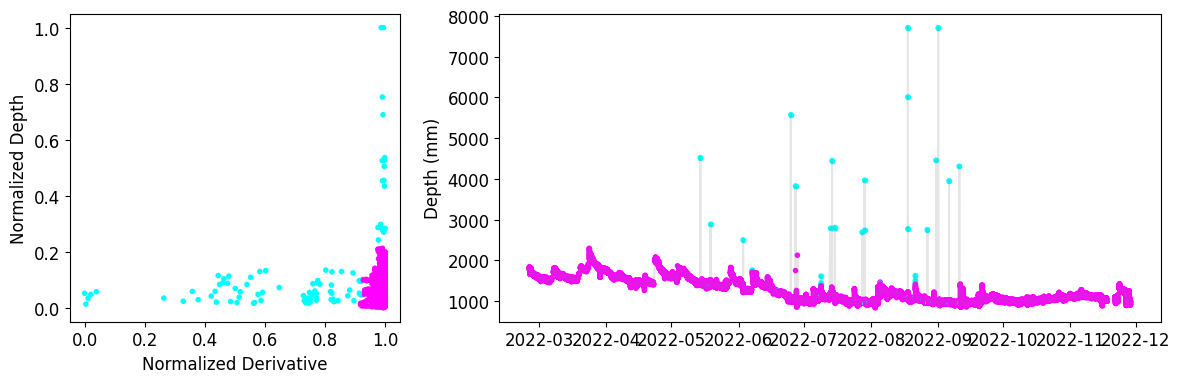

In [81]:
dbscan_detection(df)

/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


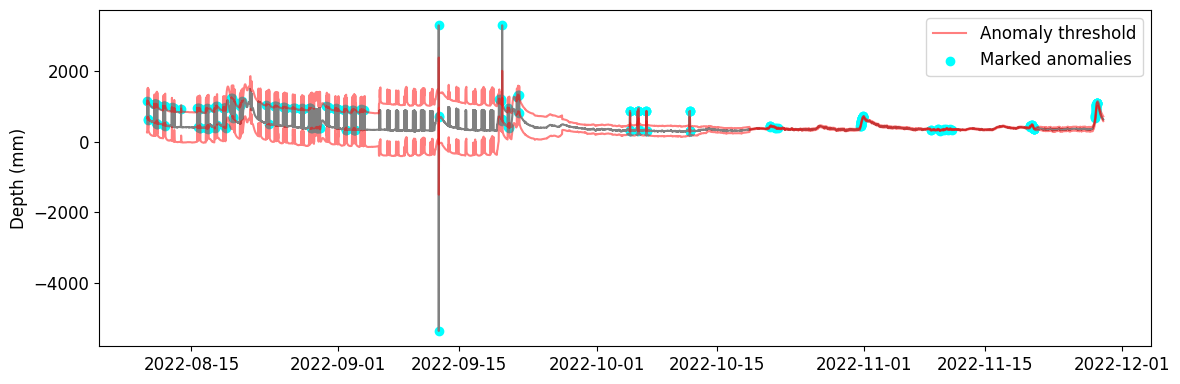

In [82]:
df = import_data(index = 68)
run_arima_detection(df, window_sz=1000, alpha=0.001)

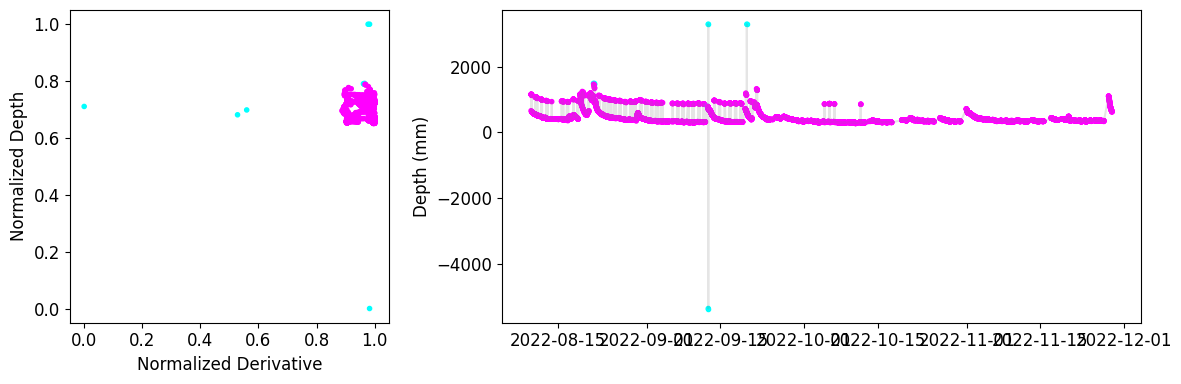

In [83]:
dbscan_detection(df)